# ThemisAI Bias Detection Demo

### Capsa automatically wraps ML workflows to achieve risk-aware learning and deployment.


In this demo, we'll be demonstrating how **CAPSA**, the model-agnostic risk awareness framework that we've developed at Themis AI, can automatically detect bias in datasets of faces. Here, the dataset we've chosen here is the Celeb-A dataset, which containts over 200K celebrity images. We create a face classification task by choosing random samples from ImageNet as negatives.

First, we import the necessary dependencies, set some important hyperparameters, and load the data

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import h5py
import sys
import glob
import functools
from train_dataloader import TrainingDatasetLoader
from tqdm import tqdm
from helper import plot_k, plot_percentile, plot_frequencies

In [2]:
training = False

In [3]:
latent_dim = 100
batch_size = 32
num_epochs = 6

### Load, prepare, and visualize the data
We normalize all data to be on a 0-1 scale.

In [4]:
data_path = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)
dataloader = TrainingDatasetLoader(data_path, batch_size=batch_size)
sample_batch_imgs, sample_batch_labels = dataloader.return_sample_batch()
test_dataloader = TrainingDatasetLoader(data_path, batch_size, training=False)
selected_inds = test_dataloader.pos_train_inds
sorted_inds = np.sort(selected_inds)
test_img = (test_dataloader.images[sorted_inds, :, :, ::-1] / 255.0).astype(np.float32)
test_label = test_dataloader.labels[sorted_inds, ...]

Opening /home/sadhanalolla/.keras/datasets/train_face.h5
Loading data into memory...
Opening /home/sadhanalolla/.keras/datasets/train_face.h5
Loading data into memory...


Here's an example face from the dataset: 

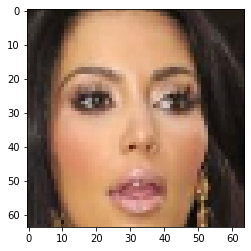

In [5]:
plt.imshow(test_img[4])

Running some preliminary analyses on the dataset, we can see that it is clearly biased in favor of females: 

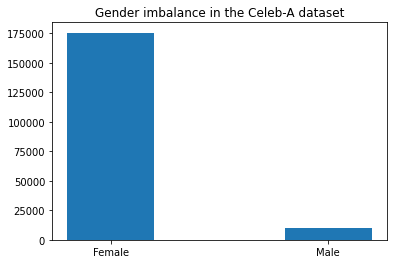

In [6]:
plot_frequencies()

### Create a baseline CNN model for classifying this data
We create a standard CNN to classify the images as faces or negatives

In [7]:
"""Function to define a standard CNN model"""

def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  model.build((None, 64, 64, 3))
  return model

standard_classifier = make_standard_classifier()

2022-08-30 10:01:39.488782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 10:01:39.517840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 10:01:39.518867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 10:01:39.520603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Using the `call` method, we can generate predictions on some sample images with our regular Keras model:

In [8]:
sample_output = standard_classifier(sample_batch_imgs)
print(sample_output)

2022-08-30 10:01:41.002986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


tf.Tensor(
[[-0.03072214]
 [-0.04305155]
 [-0.03047643]
 [-0.02251552]
 [-0.03632434]
 [-0.04556753]
 [-0.02091157]
 [-0.04374176]
 [-0.04210186]
 [-0.02820173]
 [-0.03191389]
 [-0.01701416]
 [-0.02477791]
 [-0.00503448]
 [-0.02725303]
 [-0.0089234 ]
 [-0.02269083]
 [-0.00886191]
 [-0.03240809]
 [-0.02464975]
 [-0.00787145]
 [-0.01033578]
 [-0.00864111]
 [-0.02661331]
 [-0.02721798]
 [-0.01883158]
 [-0.00218547]
 [-0.02634273]
 [-0.03001968]
 [-0.04419523]
 [-0.00049335]
 [-0.02352858]], shape=(32, 1), dtype=float32)


2022-08-30 10:01:42.778695: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Integrating Capsa to Create Risk-Aware AI Models

Now, we import capsa, our risk-aware framework. We'll be showing two different ways of "wrapping" our models so that they are risk aware.

In [9]:
from capsa import wrap, VAEWrapper, HistogramCallback

### Method 1: The *wrap(...)* function

Now, we wrap the standard classifier. In this example, we choose the VAE, or variational autoencoder, and analyze the biases in the dataset. The VAE can also be used to quantify epistemic uncertainty, which we will show here as well. With this one line, we've now created a risk-aware model!

In [10]:
wrapped_classifier = wrap(standard_classifier, aleatoric=False)

wrapping with: [<capsa.epistemic.VAE.VAEWrapper object at 0x7f962cd09b80>]


### Method 2: Directly calling metric wrapper
An alternate method of wrapping the model is using the Wrapper itself, and this is useful when we have more hyperparameters that we want to specify.

In [11]:
wrapped_classifier = VAEWrapper(
    standard_classifier,
    latent_dim=latent_dim,
    epistemic=True,
)

### Capsa models are drop-in replacements for existing models

We choose hyperparameters, load our training data, and compile the model just as we would a normal Keras model.

In [12]:
# Training hyperparameters
learning_rate = 1e-5

wrapped_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

Lastly, we fit the model. We can use any of the capabilities of a normal Keras model with the wrapped model, and fit is no exception.

In [13]:
if training:
    history = wrapped_classifier.fit(
        dataloader,
        epochs=6,
        batch_size=batch_size,
        validation_data=test_dataloader,
        callbacks=[HistogramCallback()]
    )
else:
    history = wrapped_classifier.fit(
        dataloader,
        epochs=1,
        batch_size=batch_size,
        validation_data=test_dataloader,
        callbacks=[HistogramCallback()]
    )

2404/2404 [==============================] - 48s 19ms/step - loss: 0.1000 - binary_accuracy: 0.9626 - val_loss: 0.0413 - val_binary_accuracy: 0.9862


In [14]:
if training:
    wrapped_classifier.save_weights("wrapped_model_bias_and_epistemic_shuffled_0")
else:
    path = "/data/capsa/vae_face/"
    wrapped_classifier.load_weights(path + "wrapped_model_bias_and_epistemic_shuffled_0")

Like before, we can call the Keras model again on a sample batch; this time, however, we get the output as well as the epistemic uncertainty per sample and the bias per sample

In [15]:
prediction, uncertainty, bias = wrapped_classifier(sample_batch_imgs)
print(f"Number of prediction outputs: {len(prediction)}")
print(f"Number of uncertainty outputs: {len(uncertainty)}")
print(f"Number of bias outputs: {len(bias)}")

Number of prediction outputs: 32
Number of uncertainty outputs: 32
Number of bias outputs: 32


Now that our model is trained, we load the test dataset.

We call the wrapped classifier on the test dataset and sort the dataset in order of increasing bias.

In [16]:
predictions, uncertainty, bias = wrapped_classifier(test_img, softmax=True)

In [18]:
bias = np.squeeze(bias)
sorted_bias_inds = np.argsort(bias)
sorted_biases = np.array(bias[sorted_bias_inds])
sorted_images = np.array(test_img[sorted_bias_inds])
sorted_labels = np.array(test_label[sorted_bias_inds])
sorted_predictions = np.array(predictions)[sorted_bias_inds]

Shown below are the 20 images with the lowest bias (i.e. the least represented in the dataset). We can see that varied facial position and obstructing items such as hats and sunglasses are underrepresented in this dataset

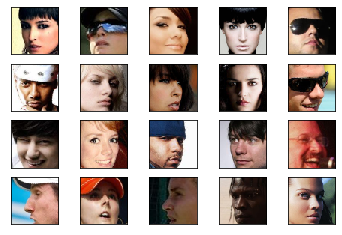

<Figure size 432x288 with 0 Axes>

In [19]:
plot_k(sorted_images[:20])

Here we see the top 20 samples that the dataset is biased towards. These are overwhemingly light-skinned females with light hair, and almost all the people in these images are directly facing the camera

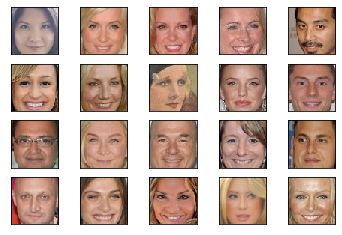

<Figure size 432x288 with 0 Axes>

In [20]:
plot_k(sorted_images[-20:])

Now, we plot the average face by percentile. The top left image shows the average face of the bottom 5th percentile in terms of bias, and we can see that the average skin tone and hair color is darker than the faces in the higher percentiles. 

In [21]:
num_percentile_intervals = 10
num_samples = len(test_img) // num_percentile_intervals
all_imgs = []
all_bias = []
all_acc = []
for percentile in range(num_percentile_intervals):
    cur_imgs = sorted_images[percentile * num_samples : (percentile + 1) * num_samples]
    cur_bias = sorted_biases[percentile * num_samples : (percentile + 1) * num_samples]
    cur_labels = sorted_labels[percentile * num_samples : (percentile + 1) * num_samples]
    cur_predictions = tf.nn.sigmoid(sorted_predictions[percentile * num_samples : (percentile + 1) * num_samples])
    avged_imgs = tf.reduce_mean(cur_imgs, axis=0)
    all_imgs.append(avged_imgs)
    all_bias.append(tf.reduce_mean(cur_bias))
    all_acc.append((cur_labels == np.rint(cur_predictions)).mean())

Next, we sort the data according to the biases and plot the average accuracy as a function of the percentile. We see here that the items with extremely low bias also have lower accuracy.

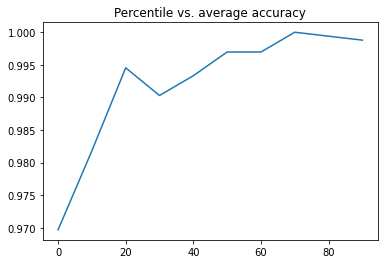

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(np.arange(num_percentile_intervals) * 10, all_acc)
plt.title("Percentile vs. average accuracy")
plt.show()
plt.clf()

Here's the average face according to percentile: as the bias in the dataset increases, the skin tone gets lighter, hair color gets lighter, and the average face becomes much more defined. 

<Figure size 432x288 with 0 Axes>

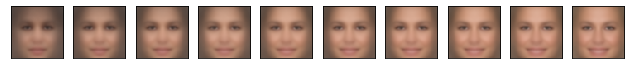

In [23]:
plot_percentile(all_imgs)

By including a single line in our normal training workflow, we've found significant bias in our dataset!

Now, we estimate the epistemic uncertainty (or model uncertainty). We see here that the items with the highest epistemic uncertainty have occlusions (shadows, masks, glasses) or abnormal lighting. This indicates that the model is the most uncertain about these predictions, even if they have a high prediction value.

In [24]:
uncertainty = np.squeeze(uncertainty)
sorted_uncertainty_inds = np.argsort(uncertainty)
sorted_uncertainty = np.array(uncertainty[sorted_uncertainty_inds])
sorted_uncertainty_images = np.array(test_img[sorted_uncertainty_inds])
sorted_uncertainty_labels = np.array(test_label[sorted_uncertainty_inds])

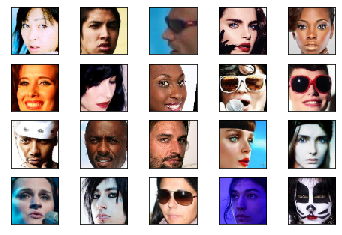

<Figure size 432x288 with 0 Axes>

In [25]:
plot_k(sorted_uncertainty_images[-20:])

Using capsa, we can also estimate the pixel-wise uncertainty of a certain image. For the specific image shown, the mouth and background have little to no uncertainty because they are well-represented in the dataset, while the contours of the mask are highlighted as this is the region the model is the most uncertain about.

In [26]:
_, _, pixel_wise_uncertainty, _ = wrapped_classifier(np.expand_dims(test_img[8741], 0), per_pixel=True)

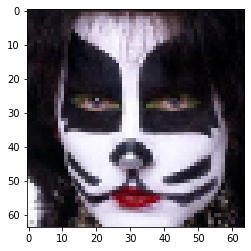

In [27]:
plt.imshow(test_img[8741])

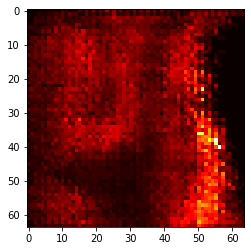

In [28]:
plt.imshow(tf.squeeze(pixel_wise_uncertainty[:, :, :, 2]), cmap='hot', interpolation='nearest')